# Gaussian Process

In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
np.random.seed(12345)
rc = {'xtick.labelsize': 10, 'ytick.labelsize': 10, 'axes.labelsize': 10, 'font.size': 10, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [14, 6]}
sns.set(rc = rc)
sns.set_style("whitegrid")

## Marginal Likelihood Implementation

### Step 1: Prepare the data

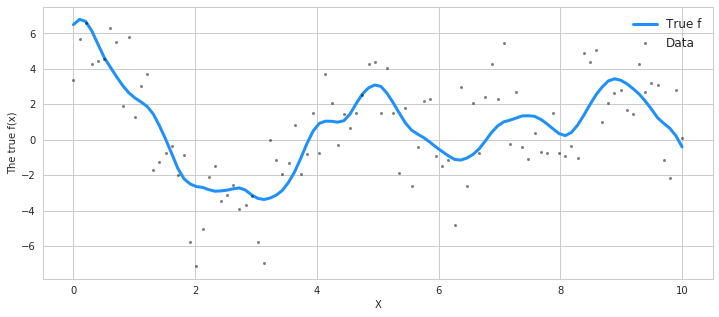

In [35]:
n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
length_scale_true = 1.0
signal_variance_true = 3.0
cov_func = signal_variance_true**2 * pm.gp.cov.Matern52(1, length_scale_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
noise_variance_true = 2.0
y = f_true + noise_variance_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("The true f(x)"); plt.legend();

### Step 2: Build the model

In [36]:
with pm.Model() as gp_model:
    length_scale = pm.Gamma("length_scale", alpha = 2, beta = 1)
    signal_variance = pm.HalfCauchy("signal_variance", beta = 5)
    
    # specify the kernel
    cov = signal_variance**2 * pm.gp.cov.ExpQuad(1, length_scale)
    gp = pm.gp.Marginal(cov_func = cov)
    
    # specify the mean function
    mean_function = pm.gp.mean.Zero()
    
    # specify the noise variance
    noise_variance = pm.HalfCauchy("noise_variance", beta = 5)
    
    # specify the likelihood
    obs = gp.marginal_likelihood("obs", X = X, y = y, noise = noise_variance)

### Step 3: Sample from the posterior

In [37]:
with gp_model:
    posterior = pm.find_MAP()

logp = -227.8, ||grad|| = 0.68245: 100%|██████████| 16/16 [00:00<00:00, 182.95it/s]  


In [38]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["length_scale", "signal_variance", "noise_variance"],
              "Value at MAP": [float(posterior["length_scale"]), float(posterior["signal_variance"]), float(posterior["noise_variance"])],
              "True value": [length_scale_true, signal_variance_true, noise_variance_true]})

,Parameter,True value,Value at MAP
0,length_scale,1.0,0.693951
1,signal_variance,3.0,2.426877
2,noise_variance,2.0,1.910109


In [39]:
# new values from x=0 to x=20
X_new = np.linspace(0, 20, 600)[:,None]

# add the GP conditional to the model, given the new X values
with gp_model:
    f_predicted = gp.conditional("f_predicted", X_new)

In [40]:
# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with gp_model:
    pred_samples = pm.sample_ppc([posterior], vars=[f_predicted], samples=2000)

100%|██████████| 2000/2000 [01:11<00:00, 27.95it/s]


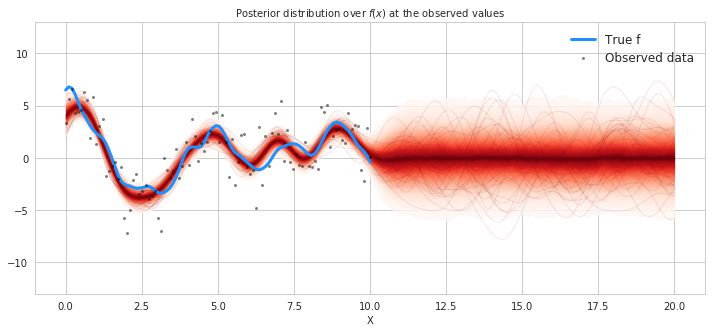

In [41]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_predicted"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [42]:
with gp_model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_ppc([posterior], vars=[y_pred], samples=2000)

100%|██████████| 2000/2000 [01:12<00:00, 27.40it/s]


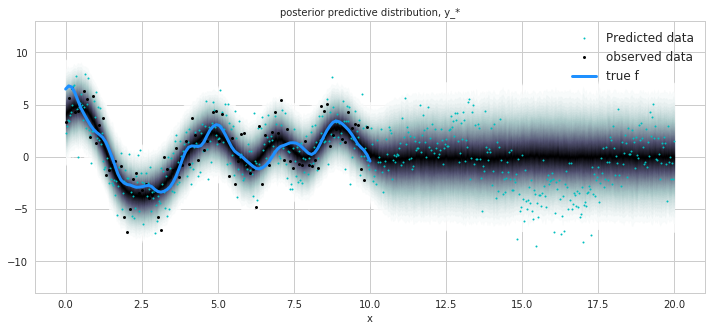

In [43]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*"); plt.legend();

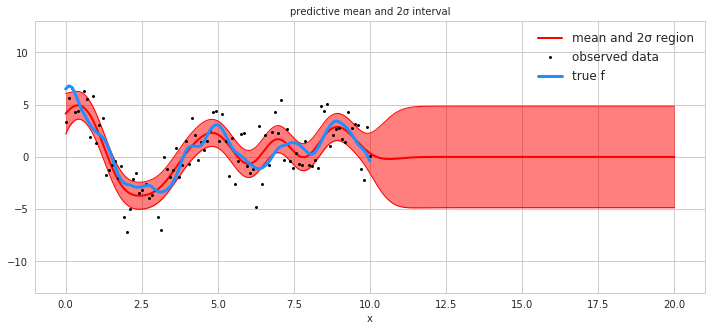

In [44]:
# predict
mu, var = gp.predict(X_new, point=posterior, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();